In [1]:
!pip install torch
!pip install git+https://github.com/openai/CLIP.git
!pip install clip-score

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import torch
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer, CLIPImageProcessor
from tqdm import tqdm
import requests
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [7]:
def compute_image_image_alignment(CLIPModel):
  tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
  preprocess_image = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

  similarities = []

  with torch.no_grad():
    for image_path1, image_path2 in image_pair_list:
      image1 = Image.open(image_path1).convert("RGB")
      image2 = Image.open(image_path2).convert("RGB")
      image_processed = preprocess_image([image1, image2], return_tensors="pt").to(CLIPModel.device)
      image_features = CLIPModel.get_image_features(**image_processed)
      cos_sim_generated = torch.nn.functional.cosine_similarity(image_features[0], image_features[1], dim=0).item()
      similarities.append(cos_sim_generated)
  return similarities

In [15]:
def compute_text_image_alignment(CLIPModel, image_list, texts):
  # videoFrames is a list of "videos" each represented by a list of images
  # texts is a list of strings to measure the similarity against
  # similarities is a list where each element corresponds to a video and is a dictionary mapping a text to a list of similarities at each frame
  tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
  preprocess_image = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

  similarities = []

  with torch.no_grad():
    for i in range(len(image_list)):

      allFrames = Image.open(image_list[i]).convert("RGB")
      images_processed = preprocess_image(allFrames, return_tensors="pt").to(CLIPModel.device)
      caption_processed = tokenizer(texts, return_tensors="pt", padding=True).to(CLIPModel.device)
      text_features = CLIPModel.get_text_features(**caption_processed)
      image_features = CLIPModel.get_image_features(**images_processed)

      res = {}
      for j, text in enumerate(texts):
        text_feature = text_features[j].unsqueeze(0)
        cos_similarities = torch.nn.functional.cosine_similarity(text_feature, image_features, dim=-1)
        res[text] = cos_similarities.tolist()
      similarities.append(res)
  return similarities

In [8]:
sims = compute_image_image_alignment(clip_model)

In [17]:
sims = compute_text_image_alignment(clip_model, ['cman_2.png', 'cman_3.png'], ['image of a chubby man standing', 'chubby'])
sims

[{'image of a chubby man standing': [0.30783990025520325],
  'chubby': [0.23796796798706055]},
 {'image of a chubby man standing': [0.31474411487579346],
  'chubby': [0.25581684708595276]}]

In [9]:
print(sims)
print(image_pair_list)

[0.811638355255127, 0.6936628222465515]
[('cman_1.png', 'cman_2.png'), ('cman_1.png', 'cman_3.png')]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd 'drive/My Drive/PGM Data/CLIP score images'

/content/drive/.shortcut-targets-by-id/1sRNTtpIL4dfHDH9diFcz8AunTk4oXAG3/PGM Data/CLIP score images


In [5]:
ls

cman_1.png  cman_3.png    cwoman_2.png  lman_2.png  man_0.png  man_2.png
cman_2.png  cwoman_1.png  lman_1.png    lman_3.png  man_1.png  man_3.png


In [6]:
# image_pair_list = [('cwoman_1.png', 'cwoman_2.png'), ('lman_1.png','man_1.png'), ('lman_2.png', 'man_2.png'), ('lman_3.png', 'man_3.png')]
image_pair_list = [('cman_1.png', 'cman_2.png'), ('cman_1.png','cman_3.png')]

In [ ]:
mv "images_1/cwoman_1.png" "images/cwoman_1.png"

In [ ]:
mv "images/cwoman_2.png" "images_1/cwoman_2.png"

In [ ]:
!python -m clip_score 'images' 'text'

Loading CLIP model: ViT-B/32
Calculating CLIP Score:
  0% 0/1 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100% 1/1 [00:00<00:00,  1.68it/s]
CLIP Score:  31.474422454833984


In [ ]:
import matplotlib.pyplot as plt

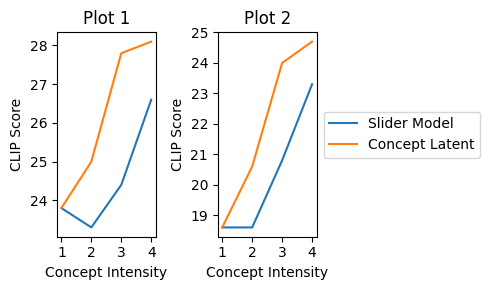

In [ ]:
figs, axs = plt.subplots(1, 2, figsize=(5, 3), sharex=False, sharey=False)
muscle_man_clip = [23.8, 23.3, 24.4, 26.6]
muscle_lman_clip = [23.8, 25.0, 27.8, 28.1]

import matplotlib.pyplot as plt

27.355377197265625
26.823278427124023

x = [1, 2, 3, 4]


# fig, ax = plt.subplots()
axs[0].plot(x, muscle_man_clip, label='Slider Model')
axs[0].plot(x, muscle_lman_clip, label='Concept Latent')
axs[0].set_xlabel('Concept Intensity')
axs[0].set_ylabel('CLIP Score')
axs[0].set_title('Plot 1')
axs[0].set_xticks(x)
# axs[0,0].legend()
# axs[0,0].legend(loc='center right', bbox_to_anchor=(0.5, 1))

muscle_clip = [18.6, 18.6, 20.8, 23.3]
lmuscle_clip = [18.6, 20.6, 24.0, 24.7]

axs[1].plot(x, muscle_clip, label='Slider Model')
axs[1].plot(x, lmuscle_clip, label='Concept Latent')
axs[1].set_xlabel('Concept Intensity')
axs[1].set_ylabel('CLIP Score')
axs[1].set_title('Plot 2')
axs[1].set_xticks(x)
# axs[0,1].legend()
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# x = [0, 8]
# chubby_man_clip = [22.6, 29.6]
# chubby_woman_clip = [24.0, 22.7]

# axs[1,0].plot(x, chubby_man_clip, color='r', label='Slider Model')
# axs[1,0].plot(x, chubby_woman_clip, color='g', label='Concept Embedding')
# axs[1,0].set_xlabel('Concept Intensity')
# axs[1,0].set_ylabel('CLIP Score')
# axs[1,0].set_title('Plot 3')
# axs[1,0].set_xticks(x)
# # axs[1,0].legend()
# # axs[1,0].legend(loc='center right', bbox_to_anchor=(0.5, 1))

# chubby_man_clip = [18.0, 23.8]
# chubby_woman_clip = [18.0, 17.2]

# axs[1,1].plot(x, chubby_man_clip, color='r', label='Slider Model')
# axs[1,1].plot(x, chubby_woman_clip, color='g', label='Concept Embedding')
# axs[1,1].set_xlabel('Concept Intensity')
# axs[1,1].set_ylabel('CLIP Score')
# axs[1,1].set_title('Plot 4')
# axs[1,1].set_xticks(x)
# # axs[1,1].legend()
# axs[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


# def plot_similarity_vs_iterations(data_dicts):
#     num_dicts = len(data_dicts)
#     num_keys = len(data_dicts[0])

#     fig, axs = plt.subplots(num_keys, num_dicts, figsize=(8, 6), sharex=True, sharey=True)  # Adjust height here

#     for i, data_dict in enumerate(data_dicts):
#         for j, (key, values) in enumerate(data_dict.items()):
#             axs[j, i].plot(range(len(values)), values, label=key)
#             axs[j, i].set_title(f'Plot {i}, {key}')
#             axs[j, i].legend()

#     for ax in axs.flat:
#         ax.set(xlabel='Frame', ylabel='Similarity')

#     plt.tight_layout()
#     plt.show()

# # Assuming sims is defined somewhere
# plot_similarity_vs_iterations(sims)